In [1]:
%%capture
! pip install transformers datasets evaluate
! pip install accelerate
! pip install --upgrade accelerate
! pip install huggingface_hub

In [2]:
from huggingface_hub import notebook_login

notebook_login()

  0%|          | 0/904 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.37      0.40      0.39       278
     neutral       0.46      0.41      0.44       376
    positive       0.24      0.26      0.25       250

    accuracy                           0.37       904
   macro avg       0.36      0.36      0.36       904
weighted avg       0.37      0.37      0.37       904



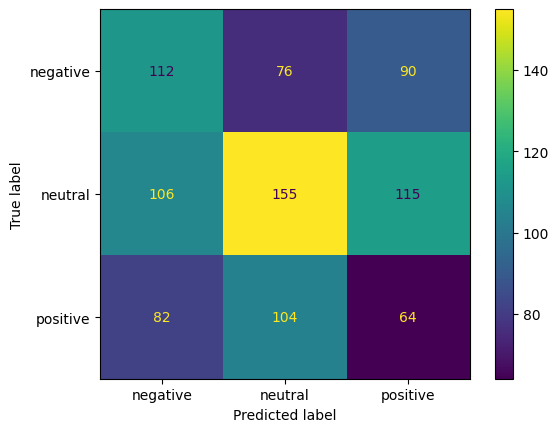

In [9]:
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from transformers import pipeline
import matplotlib.pyplot as plt


########################################################################################################################
# This script needs GPU acceleration e.g. via Google Colab
########################################################################################################################


# Define dataset structure
class NewsDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list

    def __len__(self):
        return len(self.original_list)

    def __getitem__(self, i):
        return self.original_list[i]


# Load dataset
d = load_dataset("csv", data_files="/content/drive/MyDrive/masterProject/av_test.csv")
d = d["train"]

# Instantiate dataset
dataset = NewsDataset(d["summary"])

# Create a pipeline using the desired model and tokenizer using a GPU
pipe = pipeline("text-classification", model="c-b123/distilBERT_market_finetuning" , device=0)

# # Find optimal batch size on subset of data
# for batch_size in [1, 8, 64, 256]:
#     print("-" * 30)
#     print(f"Streaming batch_size={batch_size}")
#     for out in tqdm(pipe(dataset, batch_size=batch_size), total=len(dataset)):
#         pass

# Label text data
results = []
for out in tqdm(pipe(dataset, batch_size=64), total=len(dataset)):
    results.append(out["label"])

# Add results to the original dataset
d = d.add_column("distilBERT_market", results)

# Save the DataFrame as a CSV file
# d.to_csv("/content/drive/MyDrive/masterProject/av_labelled.csv", index=False)

d.to_pandas()

# Get classification report
print(classification_report(d["finBERT"], d["distilBERT_market"], target_names=["negative", "neutral", "positive"]))

# Get confusion matrix
cm = confusion_matrix(d["finBERT"], d["distilBERT_market"], labels=["negative", "neutral", "positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])
disp.plot()
plt.show()